In [ ]:
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os

def extract_hyperparams(file_path):
    dir_name = os.path.dirname(file_path)
    config_name = os.path.basename(dir_name)
    params = {}

    bs_match = re.search(r'bs(\d+)', config_name)
    if bs_match:
        params['batch_size'] = int(bs_match.group(1))

    lr_match = re.search(r'lr([\d\.]+)', config_name)
    if lr_match:
        params['learning_rate'] = float(lr_match.group(1))

    kd_match = re.search(r'kd([\d\.]+)', config_name)
    if kd_match:
        params['kd_ratio'] = float(kd_match.group(1))

    g_match = re.search(r'G(\d+)', config_name)
    if g_match:
        params['grad_accum'] = int(g_match.group(1))

    return params

def parse_log_file(file_path):
    train_data = []
    eval_metrics_list = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            parts = [p.strip() for p in line.split("|")]
            if parts[0] == "dev":
                eval_metrics = {"avg_loss": float(parts[1].split(":")[1].strip())}
                metrics = eval(parts[2])
                eval_metrics["rougeL"] = metrics["rougeL"]
                eval_metrics["exact_match"] = metrics["exact_match"]
                eval_metrics_list.append(eval_metrics)
            elif parts[0] == "train":
                epoch = int(parts[1].split()[1])
                iteration = int(parts[2].split()[1].split("/")[0])
                loss = float(parts[4].split(":")[1].strip())
                ds_loss = float(parts[5].split(":")[1].strip())
                train_data.append((epoch, iteration, loss, ds_loss))

    return train_data, eval_metrics_list

def format_label(params):
    return f"LR={params['learning_rate']} BS={params['batch_size']} KD={params['kd_ratio']} GradAcc={params['grad_accum']}"

import numpy as np

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_training_loss(ax, train_data_list, params_list, labels, ma_window=10, color_mapping=None):
    color_cache = {}  # Save color for each label so we can reuse in eval metric
    for train_data, params, label in zip(train_data_list, params_list, labels):
        iterations = [entry[1] for entry in train_data]
        losses = [entry[2] for entry in train_data]

        # Get consistent color
        color = color_mapping[label] if color_mapping and label in color_mapping else None

        # Raw loss (transparent, no label)
        raw_line, = ax.plot(iterations, losses, linestyle='-', alpha=0.3, color=color)

        # Smoothed loss (solid line, one label)
        smoothed_losses = moving_average(losses, window_size=ma_window)
        smoothed_iterations = iterations[:len(smoothed_losses)]
        smooth_line, = ax.plot(smoothed_iterations, smoothed_losses, linestyle='-', color=raw_line.get_color(), label=label)

        # Cache color
        color_cache[label] = smooth_line.get_color()

    ax.set_title("Training Loss (Smoothed)", fontsize=16)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    #ax.set_yscale("log")
    ax.legend()
    return color_cache

def plot_eval_metric(ax, eval_metrics_list, params_list, metric_name, label, labels, step_interval=5000, color_mapping=None, linestyle_mapping=None):
    for eval_metrics, params, lbl in zip(eval_metrics_list, params_list, labels):
        eval_steps = [step_interval * i for i in range(len(eval_metrics))]
        values = [metrics[metric_name] for metrics in eval_metrics]

        color = color_mapping[lbl] if color_mapping and lbl in color_mapping else None
        linestyle = linestyle_mapping[lbl] if linestyle_mapping and lbl in linestyle_mapping else '-'
        
        ax.plot(eval_steps, values, linestyle=linestyle, color=color, label=lbl)

    ax.set_title(label, fontsize=16)
    ax.set_xlabel("Iteration")
    ax.set_ylabel(label)
    ax.legend()
    ax.set_ylim(0, 70)
    ax.set_xlim(0, 11000)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


def plot_results(file_paths, title=None, custom_labels=None):
    params_list = [extract_hyperparams(fp) for fp in file_paths]

    labels = custom_labels if custom_labels else [format_label(params) for params in params_list]

    train_data_list = []
    eval_metrics_list = []

    for file_path in file_paths:
        train_data, eval_metrics = parse_log_file(file_path)
        train_data_list.append(train_data)
        eval_metrics_list.append(eval_metrics)

    # Assign colors per model family
    family_colors = {
        "GPT2 BugNet": "#1f77b4",     # blue
        "GPT2 PyTorrent": "#2ca02c",  # green
        "Qwen2.5 PyTorrent": "#d62728" # red
    }

    # Determine group membership
    def get_family(label):
        if "GPT2" in label and "BugNet" in label:
            return "GPT2 BugNet"
        elif "GPT2" in label and "PyTorrent" in label:
            return "GPT2 PyTorrent"
        elif "Qwen2.5" in label and "PyTorrent" in label:
            return "Qwen2.5 PyTorrent"
        else:
            return "Other"

    color_mapping = {label: family_colors.get(get_family(label), "gray") for label in labels}

    # Assign linestyles for ROUGE-L
    linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (1, 1)), (0, (5, 2))]
    linestyle_mapping = {label: linestyles[i % len(linestyles)] for i, label in enumerate(labels)}

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    #change font to arial
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size']=11
    # if title:
    #     fig.suptitle(title, fontsize=20, fontweight='bold', y=1.05)

    color_mapping = plot_training_loss(axes[0], train_data_list, params_list, labels, color_mapping=color_mapping)
    plot_eval_metric(axes[1], eval_metrics_list, params_list, 'rougeL', 'ROUGE-L', labels,
                     color_mapping=color_mapping, linestyle_mapping=linestyle_mapping)

    plt.tight_layout()
    plt.show()

file_paths = [
"./logs/gpt2/sft/gpt2-base-bugnet.txt",
"./logs/gpt2/sft/gpt2-large-bugnet.txt",
"./logs/gpt2/kd/kd_bugnet.txt",

"./logs/gpt2/sft/gpt2-base-pytorrent.txt",
"./logs/gpt2/sft/gpt2-xlarge-pytorrent.txt",
"./logs/gpt2/kd/kd_pytorrent.txt",

"./logs/qwen2.5/sft/qwen2.5-0.5B.txt",
"./logs/qwen2.5/sft/qwen2.5-1.5B.txt",
"./logs/qwen2.5/kd/kd_pytorrent.txt",
]

custom_labels = [
    "GPT2 SFT base, BugNet",
    "GPT2 SFT large, BugNet",
    "GPT2 KD, BugNet",
    
    "GPT2 SFT base, PyTorrent",
    "GPT2 SFT xlarge, PyTorrent",
    "GPT2 KD PyTorrent",
    
    "Qwen2.5 0.5B SFT, PyTorrent",
    "Qwen2.5 1.5B SFT, PyTorrent",
    "Qwen2.5 KD, PyTorrent",
]

plot_results(file_paths, 
             title="Training sequence of SFT vs Knowledge Distillation",
             custom_labels=custom_labels)

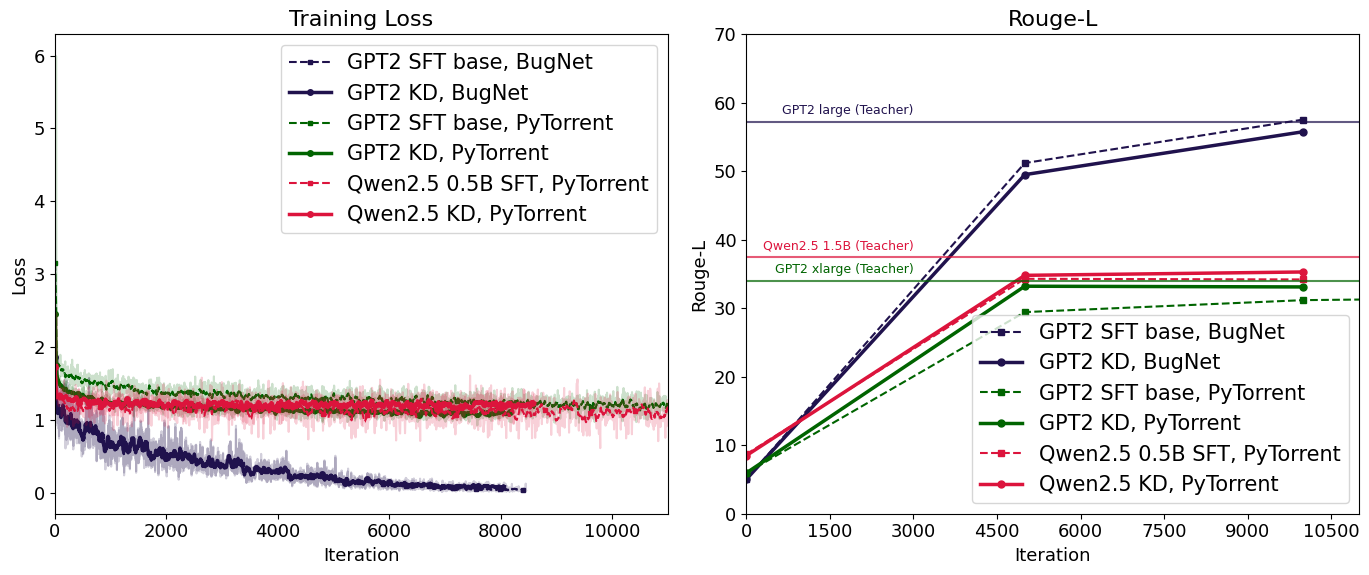

In [44]:
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import numpy as np

def extract_hyperparams(file_path):
    dir_name = os.path.dirname(file_path)
    config_name = os.path.basename(dir_name)
    params = {}

    bs_match = re.search(r'bs(\d+)', config_name)
    if bs_match:
        params['batch_size'] = int(bs_match.group(1))

    lr_match = re.search(r'lr([\d\.]+)', config_name)
    if lr_match:
        params['learning_rate'] = float(lr_match.group(1))

    kd_match = re.search(r'kd([\d\.]+)', config_name)
    if kd_match:
        params['kd_ratio'] = float(kd_match.group(1))

    g_match = re.search(r'G(\d+)', config_name)
    if g_match:
        params['grad_accum'] = int(g_match.group(1))

    return params

def parse_log_file(file_path):
    train_data = []
    eval_metrics_list = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            parts = [p.strip() for p in line.split("|")]
            if parts[0] == "dev":
                eval_metrics = {"avg_loss": float(parts[1].split(":")[1].strip())}
                metrics = eval(parts[2])
                eval_metrics["rougeL"] = metrics["rougeL"]
                eval_metrics["exact_match"] = metrics["exact_match"]
                eval_metrics_list.append(eval_metrics)
            elif parts[0] == "train":
                epoch = int(parts[1].split()[1])
                iteration = int(parts[2].split()[1].split("/")[0])
                loss = float(parts[4].split(":")[1].strip())
                ds_loss = float(parts[5].split(":")[1].strip())
                train_data.append((epoch, iteration, loss, ds_loss))

    return train_data, eval_metrics_list

def format_label(params):
    return f"LR={params['learning_rate']} BS={params['batch_size']} KD={params['kd_ratio']} GradAcc={params['grad_accum']}"

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_training_loss(ax, train_data_list, params_list, labels, ma_window=10, color_mapping=None, 
                       show_only_sft_base_and_kd=True):
    color_cache = {}  # Save color for each label so we can reuse in eval metric
    
    for train_data, params, label in zip(train_data_list, params_list, labels):
        # Skip teacher models for the loss plot
        if "large" in label.lower() or "xlarge" in label.lower() or "1.5B" in label.lower():
            continue
            
        iterations = [entry[1] for entry in train_data]
        losses = [entry[2] for entry in train_data]

        # Get consistent color
        color = color_mapping[label] if color_mapping and label in color_mapping else None

        # Raw loss (transparent, no label)
        raw_line, = ax.plot(iterations, losses, linestyle='-', alpha=0.2, color=color)
        
        # Determine if this is a KD model
        is_kd = "KD" in label
        
        # Smoothed loss (solid line with points, one label)
        smoothed_losses = moving_average(losses, window_size=ma_window)
        smoothed_iterations = iterations[:len(smoothed_losses)]
        
        # Adjust line style based on whether it's KD or SFT
        if is_kd:
            linestyle = '-'
            linewidth = 2.5
            marker = 'o'
            markersize = 4
            show_label = True
        else:  # SFT baseline
            linestyle = '--'
            linewidth = 1.5
            marker = 's'  # square markers for baseline
            markersize = 3
            show_label = True
            
        # Only show in legend if it's a baseline or KD, not a teacher
        label_to_use = label if show_label else None
        
        smooth_line, = ax.plot(smoothed_iterations, smoothed_losses, 
                              linestyle=linestyle, 
                              linewidth=linewidth,
                              marker=marker, 
                              markersize=markersize,
                              markevery=max(1, len(smoothed_iterations)//20),  # Show ~20 markers per line
                              color=raw_line.get_color(), 
                              label=label_to_use)

        # Cache color
        color_cache[label] = smooth_line.get_color()

    ax.set_title("Training Loss", fontsize=16)
    ax.set_xlim(0, 11000)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.legend()
    return color_cache

def get_best_rougeL(eval_metrics):
    rouge_scores = [metrics["rougeL"] for metrics in eval_metrics]
    return max(rouge_scores) if rouge_scores else 0

def plot_eval_metric(ax, eval_metrics_list, params_list, metric_name, label, labels, step_interval=5000, 
                     color_mapping=None, teacher_models=None):
    for i, (eval_metrics, params, lbl) in enumerate(zip(eval_metrics_list, params_list, labels)):
        # Skip plotting the teacher models as lines - will add as constant baselines
        if any(teacher in lbl for teacher in ["large", "xlarge", "1.5B"]):
            continue
            
        eval_steps = [step_interval * i for i in range(len(eval_metrics))]
        values = [metrics[metric_name] for metrics in eval_metrics]
        
        color = color_mapping[lbl] if color_mapping and lbl in color_mapping else None
        
        # Different styling for KD vs SFT models
        is_kd = "KD" in lbl
        if is_kd:
            linestyle = '-'
            linewidth = 2.5
            marker = 'o'
            markersize = 5
        else:  # SFT baseline
            linestyle = '--'
            linewidth = 1.5
            marker = 's'
            markersize = 4
            
        # Plot the line with markers
        ax.plot(eval_steps, values, 
                linestyle=linestyle, 
                linewidth=linewidth,
                marker=marker,
                markersize=markersize,
                markevery=max(1, len(eval_steps)//10),  # Show ~10 markers per line
                color=color, 
                label=lbl)

    # Add teacher baselines as horizontal lines
    if teacher_models:
        for teacher_info in teacher_models:
            teacher_file = teacher_info["file"]
            teacher_label = teacher_info["label"]
            student_label = teacher_info["student_label"]
            
            # Find the corresponding student model color
            color = color_mapping.get(student_label, "gray")
            
            # Get the best ROUGE-L score from the teacher
            _, eval_metrics = parse_log_file(teacher_file)
            best_rougeL = get_best_rougeL(eval_metrics)
            
            # Plot horizontal line
            line = ax.axhline(y=best_rougeL, linestyle='-', linewidth=1.5, color=color, alpha=0.7)
            
            # Add annotation directly on the line
            ax.text(3000, best_rougeL + 0.7, f"{teacher_label} (Teacher)", 
                   color=color, fontsize=9, horizontalalignment='right', 
                   verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

    ax.set_title(label, fontsize=16)
    ax.set_xlabel("Iteration")
    ax.set_ylabel(label)
    ax.legend()
    ax.set_ylim(0, 70)
    ax.set_xlim(0, 11000)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

def plot_results(file_paths, teacher_info, title=None, custom_labels=None):
    # Filter out teacher models from the main plots
    student_file_paths = []
    student_labels = []
    
    for file_path, label in zip(file_paths, custom_labels):
        if not any(teacher["file"] == file_path for teacher in teacher_info):
            student_file_paths.append(file_path)
            student_labels.append(label)
    
    params_list = [extract_hyperparams(fp) for fp in student_file_paths]
    
    train_data_list = []
    eval_metrics_list = []

    for file_path in student_file_paths:
        train_data, eval_metrics = parse_log_file(file_path)
        train_data_list.append(train_data)
        eval_metrics_list.append(eval_metrics)

    # Assign colors per model family
    family_colors = {
        "GPT2 BugNet": "#20124dff",     # blue
        "GPT2 PyTorrent": "darkgreen",  # green
        "Qwen2.5 PyTorrent": "crimson" # red
    }

    # Determine group membership
    def get_family(label):
        if "GPT2" in label and "BugNet" in label:
            return "GPT2 BugNet"
        elif "GPT2" in label and "PyTorrent" in label:
            return "GPT2 PyTorrent"
        elif "Qwen2.5" in label and "PyTorrent" in label:
            return "Qwen2.5 PyTorrent"
        else:
            return "Other"

    color_mapping = {label: family_colors.get(get_family(label), "gray") for label in custom_labels}

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size'] = 15

    color_mapping = plot_training_loss(axes[0], train_data_list, params_list, student_labels, 
                                       color_mapping=color_mapping)
    plot_eval_metric(axes[1], eval_metrics_list, params_list, 'rougeL', 'Rouge-L', student_labels,
                     color_mapping=color_mapping, teacher_models=teacher_info)

    plt.tight_layout()
    plt.show()

# File paths
file_paths = [
    "./logs/gpt2/sft/gpt2-base-bugnet.txt",
    "./logs/gpt2/sft/gpt2-large-bugnet.txt",  # Teacher model
    "./logs/gpt2/kd/kd_bugnet.txt",

    "./logs/gpt2/sft/gpt2-base-pytorrent.txt",
    "./logs/gpt2/sft/gpt2-xlarge-pytorrent.txt",  # Teacher model
    "./logs/gpt2/kd/kd_pytorrent.txt",

    "./logs/qwen2.5/sft/qwen2.5-0.5B.txt",
    "./logs/qwen2.5/sft/qwen2.5-1.5B.txt",  # Teacher model
    "./logs/qwen2.5/kd/kd_pytorrent.txt",
]

custom_labels = [
    "GPT2 SFT base, BugNet",
    "GPT2 SFT large, BugNet",  # Teacher model
    "GPT2 KD, BugNet",
    
    "GPT2 SFT base, PyTorrent",
    "GPT2 SFT xlarge, PyTorrent",  # Teacher model
    "GPT2 KD, PyTorrent",
    
    "Qwen2.5 0.5B SFT, PyTorrent",
    "Qwen2.5 1.5B SFT, PyTorrent",  # Teacher model
    "Qwen2.5 KD, PyTorrent",
]

# Define teacher models info for horizontal baselines
teacher_info = [
    {
        "file": "./logs/gpt2/sft/gpt2-large-bugnet.txt",
        "label": "GPT2 large",
        "student_label": "GPT2 KD, BugNet"
    },
    {
        "file": "./logs/gpt2/sft/gpt2-xlarge-pytorrent.txt",
        "label": "GPT2 xlarge",
        "student_label": "GPT2 KD, PyTorrent"
    },
    {
        "file": "./logs/qwen2.5/sft/qwen2.5-1.5B.txt",
        "label": "Qwen2.5 1.5B",
        "student_label": "Qwen2.5 KD, PyTorrent" 
    }
]

plot_results(file_paths, 
             teacher_info=teacher_info,
             title="Training sequence of SFT vs Knowledge Distillation",
             custom_labels=custom_labels)

/tmp/ipykernel_1816852/3637687813.py:140: UserWarning: Mismatched number of handles and labels: len(handles) = 3 len(labels) = 5
  ax.legend(handles=handles, labels=labels + ['SFT', 'KD'], loc='upper right')


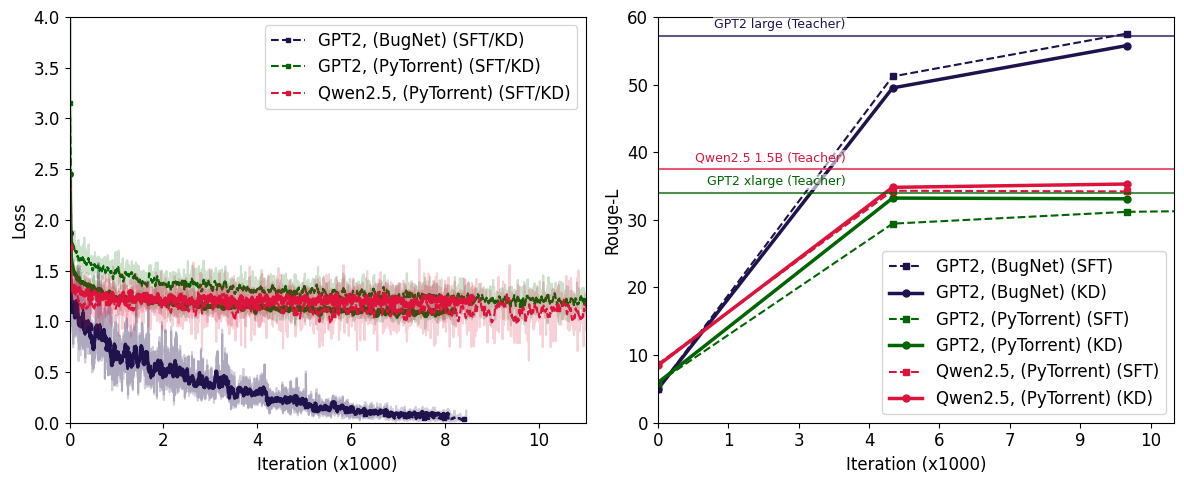

In [56]:
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import numpy as np

def extract_hyperparams(file_path):
    dir_name = os.path.dirname(file_path)
    config_name = os.path.basename(dir_name)
    params = {}

    bs_match = re.search(r'bs(\d+)', config_name)
    if bs_match:
        params['batch_size'] = int(bs_match.group(1))

    lr_match = re.search(r'lr([\d\.]+)', config_name)
    if lr_match:
        params['learning_rate'] = float(lr_match.group(1))

    kd_match = re.search(r'kd([\d\.]+)', config_name)
    if kd_match:
        params['kd_ratio'] = float(kd_match.group(1))

    g_match = re.search(r'G(\d+)', config_name)
    if g_match:
        params['grad_accum'] = int(g_match.group(1))

    return params

def parse_log_file(file_path):
    train_data = []
    eval_metrics_list = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            parts = [p.strip() for p in line.split("|")]
            if parts[0] == "dev":
                eval_metrics = {"avg_loss": float(parts[1].split(":")[1].strip())}
                metrics = eval(parts[2])
                eval_metrics["rougeL"] = metrics["rougeL"]
                eval_metrics["exact_match"] = metrics["exact_match"]
                eval_metrics_list.append(eval_metrics)
            elif parts[0] == "train":
                epoch = int(parts[1].split()[1])
                iteration = int(parts[2].split()[1].split("/")[0])
                loss = float(parts[4].split(":")[1].strip())
                ds_loss = float(parts[5].split(":")[1].strip())
                train_data.append((epoch, iteration, loss, ds_loss))

    return train_data, eval_metrics_list

def format_label(params):
    return f"LR={params['learning_rate']} BS={params['batch_size']} KD={params['kd_ratio']} GradAcc={params['grad_accum']}"

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def get_model_family(label):
    if "GPT2" in label and "BugNet" in label:
        return "GPT2, (BugNet)"
    elif "GPT2" in label and "PyTorrent" in label:
        return "GPT2, (PyTorrent)"
    elif "Qwen2.5" in label and "PyTorrent" in label:
        return "Qwen2.5, (PyTorrent)"
    else:
        return "Other"

def plot_training_loss(ax, train_data_list, params_list, labels, ma_window=10, color_mapping=None):
    color_cache = {}  # Save color for each label so we can reuse in eval metric
    
    # Track which model families we've already added to the legend
    plotted_families = set()
    
    for train_data, params, label in zip(train_data_list, params_list, labels):
        # Skip teacher models for the loss plot
        if "large" in label.lower() or "xlarge" in label.lower() or "1.5B" in label.lower():
            continue
            
        model_family = get_model_family(label)
        is_kd = "KD" in label
        
        iterations = [entry[1] for entry in train_data]
        losses = [entry[2] for entry in train_data]

        # Get consistent color for the model family
        color = color_mapping[model_family] if color_mapping and model_family in color_mapping else None

        # Raw loss (transparent, no label)
        raw_line, = ax.plot(iterations, losses, linestyle='-', alpha=0.2, color=color)
        
        # Smoothed loss (solid line with points)
        smoothed_losses = moving_average(losses, window_size=ma_window)
        smoothed_iterations = iterations[:len(smoothed_losses)]
        
        # Adjust line style based on whether it's KD or SFT
        if is_kd:
            linestyle = '-'
            linewidth = 2.5
            marker = 'o'
            markersize = 4
            style_label = "KD"
        else:  # SFT baseline
            linestyle = '--'
            linewidth = 1.5
            marker = 's'  # square markers for baseline
            markersize = 3
            style_label = "SFT"
            
        # Only add to legend if we haven't seen this model family before
        if model_family not in plotted_families:
            label_to_use = model_family+f" (SFT/KD)"
            plotted_families.add(model_family)
        else:
            label_to_use = None
        
        smooth_line, = ax.plot(smoothed_iterations, smoothed_losses, 
                              linestyle=linestyle, 
                              linewidth=linewidth,
                              marker=marker, 
                              markersize=markersize,
                              markevery=max(1, len(smoothed_iterations)//20),
                              color=raw_line.get_color(), 
                              label=label_to_use)

        # Cache color
        color_cache[label] = smooth_line.get_color()
        color_cache[model_family] = smooth_line.get_color()

    # Add a legend for SFT vs KD line styles
    #sft_line = plt.Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, marker='s', markersize=3, label='SFT')
    #kd_line = plt.Line2D([0], [0], color='gray', linestyle='-', linewidth=2.5, marker='o', markersize=4, label='KD')
    
    # Get existing handles and labels
    handles, labels = ax.get_legend_handles_labels()
    
    # Add style indicators to the legend
    #handles.extend([sft_line, kd_line])
    
    ax.legend(handles=handles, labels=labels + ['SFT', 'KD'], loc='upper right')
    
    #ax.set_title("Training Loss", fontsize=16)
    # ax.set_xlabel("Iteration")
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}'))
    # Optional: you can label it more clearly
    ax.set_xlabel("Iteration (x1000)")
    ax.set_xlim(0, 11000)
    ax.set_ylim(0, 4)
    ax.set_ylabel("Loss")
    return color_cache
import matplotlib.ticker as ticker
def get_best_rougeL(eval_metrics):
    rouge_scores = [metrics["rougeL"] for metrics in eval_metrics]
    return max(rouge_scores) if rouge_scores else 0

def plot_eval_metric(ax, eval_metrics_list, params_list, metric_name, label, labels, step_interval=5000, 
                     color_mapping=None, teacher_models=None):
    # Track which model families we've already added to the legend
    plotted_families = set()
    
    for i, (eval_metrics, params, lbl) in enumerate(zip(eval_metrics_list, params_list, labels)):
        # Skip plotting the teacher models as lines
        if any(teacher in lbl for teacher in ["large", "xlarge", "1.5B"]):
            continue
            
        model_family = get_model_family(lbl)
        is_kd = "KD" in lbl
        
        eval_steps = [step_interval * i for i in range(len(eval_metrics))]
        values = [metrics[metric_name] for metrics in eval_metrics]
        
        color = color_mapping[model_family] if color_mapping and model_family in color_mapping else None
        
        # Different styling for KD vs SFT models
        if is_kd:
            linestyle = '-'
            linewidth = 2.5
            marker = 'o'
            markersize = 5
            style_label = "KD"
        else:  # SFT baseline
            linestyle = '--'
            linewidth = 1.5
            marker = 's'
            markersize = 4
            style_label = "SFT"
        
        # Only add to legend if we haven't seen this combination before
        combined_label = f"{model_family} ({style_label})"
        if combined_label not in plotted_families:
            label_to_use = combined_label
            plotted_families.add(combined_label)
        else:
            label_to_use = None
            
        # Plot the line with markers
        ax.plot(eval_steps, values, 
                linestyle=linestyle, 
                linewidth=linewidth,
                marker=marker,
                markersize=markersize,
                markevery=max(1, len(eval_steps)//10),
                color=color, 
                label=label_to_use)

    # Add teacher baselines as horizontal lines
    if teacher_models:
        for teacher_info in teacher_models:
            teacher_file = teacher_info["file"]
            teacher_label = teacher_info["label"]
            student_label = teacher_info["student_label"]
            model_family = get_model_family(student_label)
            
            # Find the corresponding model family color
            color = color_mapping.get(model_family, "gray")
            
            # Get the best ROUGE-L score from the teacher
            _, eval_metrics = parse_log_file(teacher_file)
            best_rougeL = get_best_rougeL(eval_metrics)
            
            # Plot horizontal line
            line = ax.axhline(y=best_rougeL, linestyle='-', linewidth=1.5, color=color, alpha=0.7)
            
            # Add annotation directly on the line
            ax.text(4000, best_rougeL + 0.7, f"{teacher_label} (Teacher)", 
                   color=color, fontsize=9, horizontalalignment='right', 
                   verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

    #ax.set_title(label, fontsize=16)
    # ax.set_xlabel("Iteration")
        # Format x-axis to display thousands as K (i.e., 1K instead of 1000)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}'))
    # Optional: you can label it more clearly
    ax.set_xlabel("Iteration (x1000)")
    ax.set_ylabel(label)
    ax.legend()
    ax.set_ylim(0, 60)
    ax.set_xlim(0, 11000)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

def plot_results(file_paths, teacher_info, title=None, custom_labels=None):
    # Filter out teacher models from the main plots
    student_file_paths = []
    student_labels = []
    
    for file_path, label in zip(file_paths, custom_labels):
        if not any(teacher["file"] == file_path for teacher in teacher_info):
            student_file_paths.append(file_path)
            student_labels.append(label)
    
    params_list = [extract_hyperparams(fp) for fp in student_file_paths]
    
    train_data_list = []
    eval_metrics_list = []

    for file_path in student_file_paths:
        train_data, eval_metrics = parse_log_file(file_path)
        train_data_list.append(train_data)
        eval_metrics_list.append(eval_metrics)

    # Assign colors per model family - simplified to just the three model families
    family_colors = {
        "GPT2, (BugNet)": "#20124dff",     # blue
        "GPT2, (PyTorrent)": "darkgreen",  # green
        "Qwen2.5, (PyTorrent)": "crimson", # red
    }

    color_mapping = family_colors

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=100)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size'] = 12

    color_mapping = plot_training_loss(axes[0], train_data_list, params_list, student_labels, 
                                       color_mapping=color_mapping)
    plot_eval_metric(axes[1], eval_metrics_list, params_list, 'rougeL', 'Rouge-L', student_labels,
                     color_mapping=color_mapping, teacher_models=teacher_info)

    plt.tight_layout()
    plt.show()

# File paths
file_paths = [
    "./logs/gpt2/sft/gpt2-base-bugnet.txt",
    "./logs/gpt2/sft/gpt2-large-bugnet.txt",  # Teacher model
    "./logs/gpt2/kd/kd_bugnet.txt",

    "./logs/gpt2/sft/gpt2-base-pytorrent.txt",
    "./logs/gpt2/sft/gpt2-xlarge-pytorrent.txt",  # Teacher model
    "./logs/gpt2/kd/kd_pytorrent.txt",

    "./logs/qwen2.5/sft/qwen2.5-0.5B.txt",
    "./logs/qwen2.5/sft/qwen2.5-1.5B.txt",  # Teacher model
    "./logs/qwen2.5/kd/kd_pytorrent.txt",
]

custom_labels = [
    "GPT2 SFT base, BugNet",
    "GPT2 SFT large, BugNet",  # Teacher model
    "GPT2 KD, BugNet",
    
    "GPT2 SFT base, PyTorrent",
    "GPT2 SFT xlarge, PyTorrent",  # Teacher model
    "GPT2 KD, PyTorrent",
    
    "Qwen2.5 0.5B SFT, PyTorrent",
    "Qwen2.5 1.5B SFT, PyTorrent",  # Teacher model
    "Qwen2.5 KD, PyTorrent",
]

# Define teacher models info for horizontal baselines
teacher_info = [
    {
        "file": "./logs/gpt2/sft/gpt2-large-bugnet.txt",
        "label": "GPT2 large",
        "student_label": "GPT2 KD, BugNet"
    },
    {
        "file": "./logs/gpt2/sft/gpt2-xlarge-pytorrent.txt",
        "label": "GPT2 xlarge",
        "student_label": "GPT2 KD, PyTorrent"
    },
    {
        "file": "./logs/qwen2.5/sft/qwen2.5-1.5B.txt",
        "label": "Qwen2.5 1.5B",
        "student_label": "Qwen2.5 KD, PyTorrent" 
    }
]

plot_results(file_paths, 
             teacher_info=teacher_info,
             title="Training sequence of SFT vs Knowledge Distillation",
             custom_labels=custom_labels)


# OUtputs RL

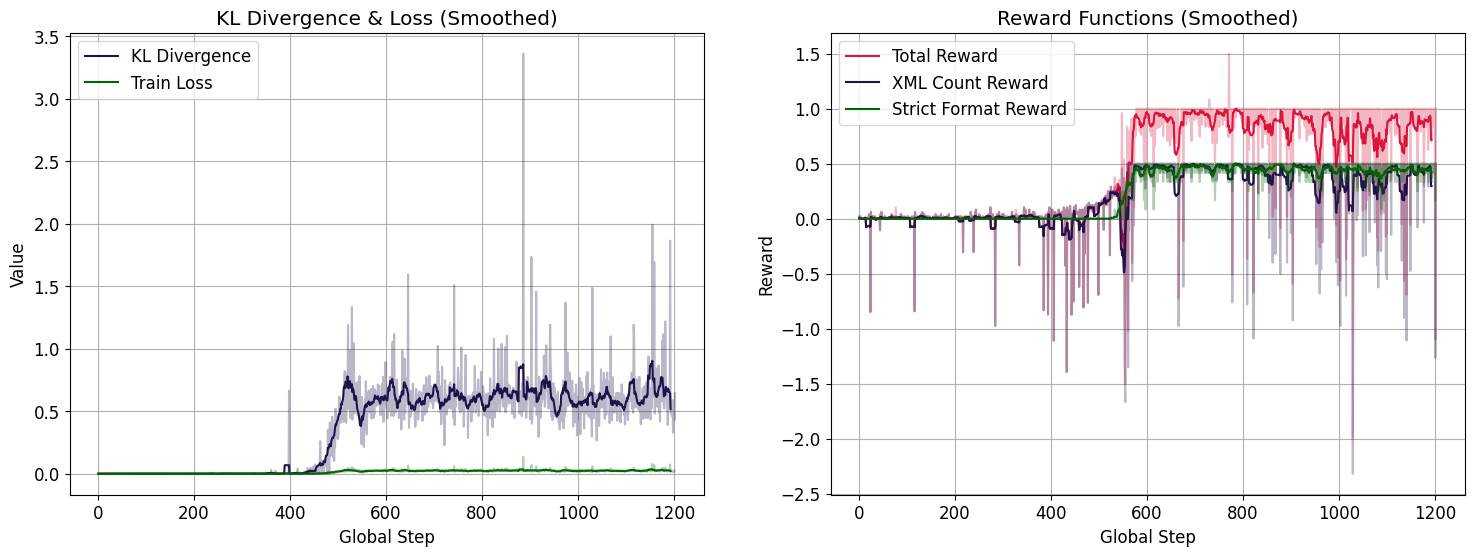

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

# --- Parameters ---
csv_files = sorted(glob.glob("/home/users/ap794/final_project_distillLLM/aleGRPO/outputs/logs/*.csv"))  # Adjust the path to your CSV files
ma_window = 10  # Moving average window

# --- Metrics to plot ---
left_metrics = {
    "outputs - train/kl": "KL Divergence",
    "outputs - train/loss": "Train Loss"
}

right_metrics = {
    "outputs - train/reward": "Total Reward",
    "outputs - train/rewards/xmlcount_reward_func": "XML Count Reward",
    "outputs - train/rewards/strict_format_reward_func": "Strict Format Reward"
}

# --- Moving average helper ---
def moving_average(values, window=10):
    return np.convolve(values, np.ones(window)/window, mode='valid')

# --- Load and parse data ---
dfs = [pd.read_csv(f) for f in csv_files]

family_colors = ["#20124dff", "darkgreen", "crimson"]  # blue, green, red

# Create a cyclical color assignment
from itertools import cycle
color_cycle = cycle(family_colors)

# Remap metrics to new colors using the cycle
metric_color_map = {}
for metric in list(left_metrics.keys()) + list(right_metrics.keys()):
    metric_color_map[metric] = next(color_cycle)
metric_colors = {
    "outputs - train/kl": family_colors[0],
    "outputs - train/loss": family_colors[1],
    "outputs - train/reward": family_colors[2],
    "outputs - train/rewards/xmlcount_reward_func": family_colors[0],
    "outputs - train/rewards/strict_format_reward_func": family_colors[1]
}


# --- Define your custom color palette ---
family_colors = ["#20124dff", "darkgreen", "crimson"]  # blue, green, red

# Create a cyclical color assignment
from itertools import cycle
color_cycle = cycle(family_colors)

# Remap metrics to new colors using the cycle
metric_color_map = {}
for metric in list(left_metrics.keys()) + list(right_metrics.keys()):
    metric_color_map[metric] = next(color_cycle)


# --- Plot ---
plt.figure(figsize=(18, 6))
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12

# Left subplot: KL and Loss
ax1 = plt.subplot(1, 2, 1)
for metric, label in left_metrics.items():
    for df in dfs:
        if metric in df.columns:
            steps = df["train/global_step"]
            values = df[metric]
            ax1.plot(steps, values, alpha=0.3, color=metric_colors[metric])
            smoothed = moving_average(values, ma_window)
            ax1.plot(steps[:len(smoothed)], smoothed, label=label, color=metric_colors[metric])
ax1.set_title("KL Divergence & Loss (Smoothed)")
ax1.set_xlabel("Global Step")
ax1.set_ylabel("Value")
ax1.legend()
ax1.grid(True)

# Right subplot: Rewards
ax2 = plt.subplot(1, 2, 2)
for metric, label in right_metrics.items():
    for df in dfs:
        if metric in df.columns:
            steps = df["train/global_step"]
            values = df[metric]
            ax2.plot(steps, values, alpha=0.3, color=metric_colors[metric])
            smoothed = moving_average(values, ma_window)
            ax2.plot(steps[:len(smoothed)], smoothed, label=label, color=metric_colors[metric])
ax2.set_title("Reward Functions (Smoothed)")
ax2.set_xlabel("Global Step")
ax2.set_ylabel("Reward")
ax2.legend()
ax2.grid(True)
